> ***Note:*** _This can be a pair programming activity or done independently._

The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data
1. Produce a trained model to predict future sales numbers
1. Assemble your findings in a report

Try your best to tune your model. It can be difficult, but don't worry - timeseries analysis is just a difficult and specialized topic.


- Assemble observations and graphs as well as timeseries models in a notebook.

In [3]:
#### Starter code

import pandas as pd
import numpy as np


%matplotlib inline
# get the Datas
data = pd.read_csv('../datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [4]:
import datetime

#### Deliverable

**Look back at the readme from wednesday's lecture on timeseries for good information about these models and acf/pacf plots!**

1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.
- Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?
- Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and create an autocorrelation and partial autocorrelation plot.
- *BONUS:* What do the acf() and pacf() plots say about the type of model you want to build?
- Split the weekly sales data in a training and test set - using 75% of the data for training.
- "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)
- Create an AR(1) model on the training data and compute the mean absolute error of the predictions. How effective is this model?
- Plot the residuals - where are their significant errors?
- Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?
- Assemble your findings, including any useful graphs.

#### Additional Resources

1. [ARMA Example](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_arma.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

In [5]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

#### 1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [6]:
store1 = data[data['Store'] == 1]
# there are about 36 different stores in this dataset.

In [7]:
store1_sales = pd.DataFrame(store1['Weekly_Sales'].groupby(store1.index).sum())
store1_sales.dtypes
# Grouped weekly sales by store 1

Weekly_Sales    float64
dtype: object

In [8]:
#remove date from index to change its dtype because it clearly isnt acceptable.
store1_sales.reset_index(inplace = True)

#converting 'date' column to a datetime type
store1_sales['Date'] = pd.to_datetime(store1_sales['Date'])
# resetting date back to the index
store1_sales.set_index('Date',inplace = True)



store1_sales.head()
# I think its a datetime object now.  

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [9]:
store1_sales.index.dtype
#confirmed

dtype('<M8[ns]')

#### 2. Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

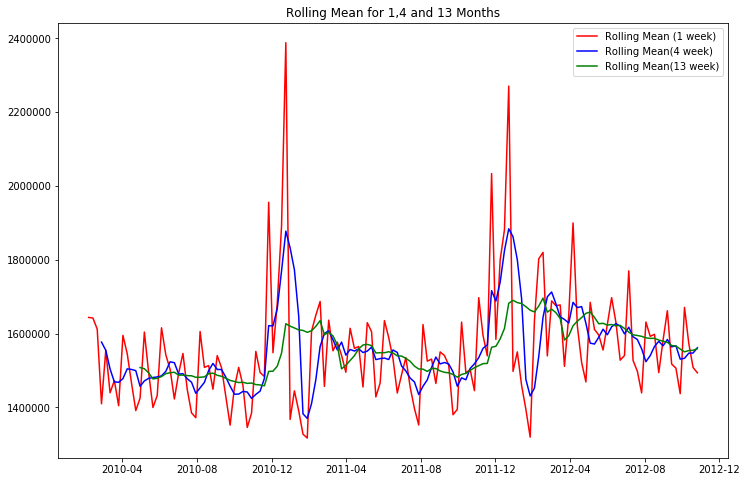

In [13]:
rolmean1 = store1_sales.rolling(1).mean()
rolmean4 = store1_sales.rolling(4).mean()
rolmean13 = store1_sales.rolling(13).mean()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
mean = plt.plot(rolmean1, color='red', label='Rolling Mean (1 week)')
mean = plt.plot(rolmean4, color='blue', label='Rolling Mean(4 week)')
mean = plt.plot(rolmean13, color='green', label='Rolling Mean(13 week)')

plt.legend(loc='best')
plt.title('Rolling Mean for 1,4 and 13 Months')
plt.show()

There are clearly spikes in the early year around january and february.  Most likely the result of huge increases for holiday spending in November and December.

These spikes are follew by sharp falls which could indicate either that there is a leading up and sudden drop off before and then after the holidays and or, there is a significant decrease in spending immediately following the holiday season.

I choose to Plot 1, 4 and 13 weeks, because those represent week to week as a default for comparison, 4 weeks is about a month and 13 weeks is a season (3 months)

#### 3. Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.

In [14]:
print('1 Week Lag AutoCorr', store1_sales['Weekly_Sales'].autocorr(lag=1))
print('2 Week Lag AutoCorr', store1_sales['Weekly_Sales'].autocorr(lag=2))
print('52 Week Lag AutoCorr', store1_sales['Weekly_Sales'].autocorr(lag=52))


1 Week Lag AutoCorr 0.3021582794113126
2 Week Lag AutoCorr 0.12741313055390097
52 Week Lag AutoCorr 0.8953760294777008


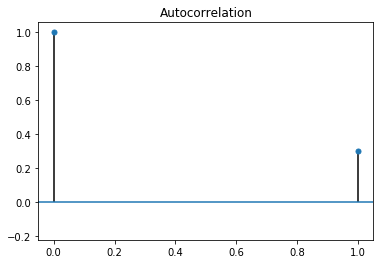

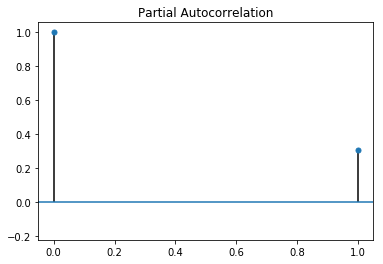

In [15]:
# 1 Month Autocorr and Partial Autocorr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(store1_sales, lags = 1)
plot_pacf(store1_sales, lags = 1)

# If you do not use plt.show() it will plot the same vize twice.
# This may be a bug you can fix and submit, to contribute to open source!
plt.show()


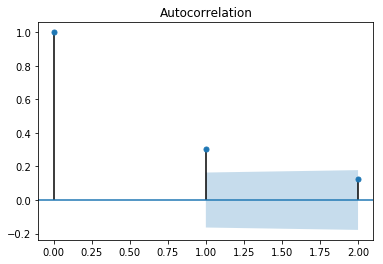

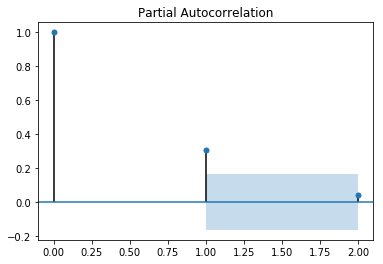

In [16]:
# 2 Month Autocorr and Partial Autocorr

plot_acf(store1_sales, lags =2)
plot_pacf(store1_sales, lags =2)

plt.show()

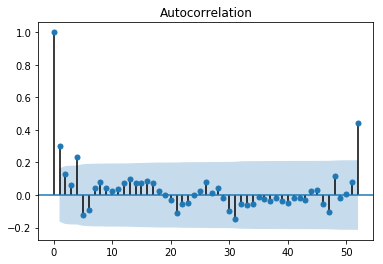

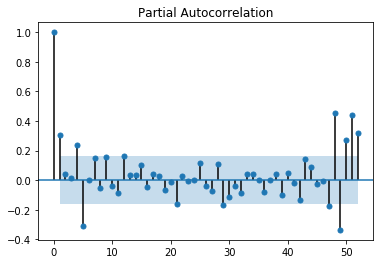

In [17]:
# 52 Month Autocorr and Partial Autocorr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(store1_sales, lags =52)
plot_pacf(store1_sales, lags =52)


plt.show()

## 4. BONUS: What do the acf() and pacf() plots say about the type of model you want to build?

The filled blue space is representative of 95% confidence interval.  That being said, those points the we see inside the blue space are likely to be noise an not prove to have any valuable correlation.  With the default 95% confidence interval we can expect that 5% of observations could fall outside this boundary, and those that do are ones we should consider for further investigation as far as correlation.

There is that one point, the first lagged point.  Look at how correlated it is.  1.0.  WOW!... Why is that there, i don't know, maybe as a reference but that is representing a lag of 0 or the same point in time, which shocker, is highly correlated with itself.


- lag 1.  There is not enough information for us to create a confidence interval range and justify if that point represented of 1 lag was outside or in it to make a valuealbe assessment of its correlation.

- lag 2. From the confidence range represented we have one point that appears outside but its also the first lagged observation

_For lags of 1 and 2 the Partial Autocorr and Autocorr is the same and no additional inferences can be made_

- lag 52.  Now that we see several lagged periods together we can really begin to access those that stick out from the crowd
> - 1 Week Lag: We would think that a weeks sales would be relative to the week before or after to an extent.
> - 4 Week Lag: 4 Weeks in a month so its like the monthly affect.
> - **5 Week Lag: This is very interesting 5 week negative correlation....**
> - 48 Week Lag: A Month before a year later.
> - 51 Week Lag: the week before a year later, 
> - 52 Week Lag: 52 weeks in a year so this is the same week a year later



#### 5. Split the weekly sales data in a training and test set - using 75% of the data for training.

In [18]:
store1_sales.shape

(143, 1)

In [19]:
#shape of information is 143 rows.  
143*0.75
# first 107 rows for training, next 36 rows for testing?

107.25

In [20]:
train = store1_sales.head(107)

In [21]:
test = store1_sales.tail(36)

#### 6. "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)

```python
series.diff(periods = n)
```

In [22]:
store1_sales['Weekly_Sales'].diff(periods =1)

Date
2010-02-05          NaN
2010-02-12     -1733.46
2010-02-19    -29989.27
2010-02-26   -202240.58
2010-03-05    145079.09
2010-03-12   -115265.09
2010-03-19     32974.20
2010-03-26    -68085.87
2010-04-02    190538.36
2010-04-09    -49549.75
2010-04-16    -79360.25
2010-04-23    -74802.16
2010-04-30     33844.59
2010-05-07    178854.41
2010-05-14   -109703.62
2010-05-21    -94589.43
2010-05-28     32407.88
2010-06-04    183454.76
2010-06-11    -72963.62
2010-06-18    -39277.03
2010-06-25    -80572.46
2010-07-02     69706.54
2010-07-09     53656.04
2010-07-16    -97135.26
2010-07-23    -63873.72
2010-07-30    -13078.60
2010-08-06    233505.18
2010-08-13    -97254.02
2010-08-20      4842.73
2010-08-27    -63937.57
                ...    
2012-04-06    250072.25
2012-04-13   -278645.18
2012-04-20    -99453.83
2012-04-27    -52649.50
2012-05-04    215591.62
2012-05-11    -73423.94
2012-05-18    -15194.18
2012-05-25    -40457.32
2012-06-01     69033.03
2012-06-08     72753.38
2012-06-15 

**_Idk about you, but this is pretty cool!_**

#### 7.Create an AR(1) model on the training data and compute the mean absolute error of the predictions. 
####    How effective is this model?

In [23]:
train.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [24]:
from statsmodels.tsa.arima_model import AR

train_values = train['Weekly_Sales'].values
train_dates = train.index


AR1 = AR(train_values, train_dates).fit()

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [25]:
test.tail()

,Weekly_Sales
Date,
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81
2012-10-19,1508068.77
2012-10-26,1493659.74


In [28]:
test_values = test['Weekly_Sales'].values
test_dates = test.index

# The AR Predict takes a start and and end date as values and not a list.
start = '2012-02-24'
end = '2012-10-26'


AR1_pred = AR1.predict(start=start, end = end)

AR1_pred

array([1795228.10714292, 1766495.7297176 , 1622400.28193731,
       1613063.83727759, 1544992.60960354, 1513261.11423744,
       1486362.75532597, 1577041.86981068, 1558382.23804311,
       1569340.66506128, 1606072.69483   , 1630835.38972134,
       1594763.31066862, 1587158.93995261, 1586802.38437701,
       1561910.24483898, 1545662.45927638, 1555010.63303531,
       1550563.48947547, 1551544.43043052, 1563093.82933678,
       1571660.41953243, 1563951.31722854, 1570319.72595791,
       1571610.36511784, 1563623.57893903, 1558178.80937076,
       1561328.24821122, 1557566.03575113, 1554007.43735003,
       1557778.38631106, 1559853.20239311, 1558155.97266884,
       1560258.65311007, 1562204.01296244, 1560376.90664805])

For the AR(1) model we can also use ARMA and ARIMA with specific parameters.

```python

model = ARMA(endog = VALUES, dates = DATES, order = (1,0) )

model = ARIMA(endog = VALUES, dates = DATES, order = (1,0,0) )

```

- ARMA Order is represented as (p,q)
- ARIMA Order is represented as (p,d,q)
> - p = AutoRegression
> - q = Moving Average
> - d = Differences 

In [29]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_values, AR1_pred)

79376.327781106

On average we're off about $80,000 a week in sales.  considering our range is 1.4m - 1.7m, thats about a 4.5 - 5.5 percent error.

## 8. Plot the residuals - where are their significant errors?

In [30]:
AR1_residuals = test_values - AR1_pred

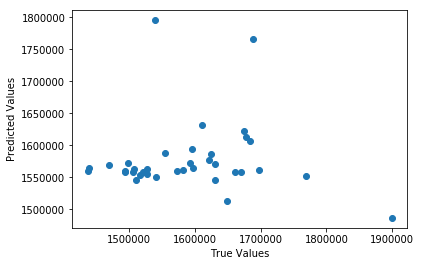

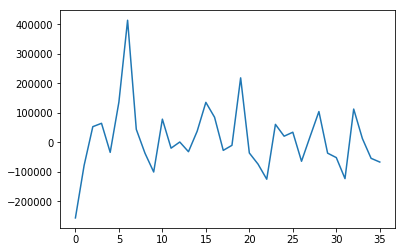

In [31]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, AR1_pred)
plt.show()

plt.plot(AR1_residuals)
plt.show()

Probably most significant errors would be those 2 major peaks happening at days 6 and 19.
which i believe cooresponds to 2012-03-30 and 2012-06-29.

#### 9. Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

In [34]:
from statsmodels.tsa.arima_model import ARMA

In [35]:
AR2 = ARMA(endog = train_values, dates = train_dates, order = (2,0)).fit()

# Same start and end we outlined earlier.
AR2_pred = AR2.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_pred)

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[in

81203.23935441981

In [36]:
AR2_2 = ARMA(endog = train_values, dates = train_dates, order = (2,2)).fit()

# Same start and end we outlined earlier.
AR2_2_pred = AR2_2.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_2_pred)

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


80502.72104006064

Looks like both of the MAE were worse from the original AR, the MAE of the ARMA(2,2) was slightly better than the ARMA(2,0) however.

#### 10. Assemble your findings, including any useful graphs.

In [37]:
AR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Mon, 29 Oct 2018   AIC                           2876.963
Time:                        09:30:50   BIC                           2887.655
Sample:                    02-05-2010   HQIC                          2881.298
                         - 02-17-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.y        0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.y        0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3588           +0.0000j            7.3588            0.5000
-----------------------------------------------------------------------------
"""

In [38]:
AR2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144113.339
Date:                Mon, 29 Oct 2018   AIC                           2863.563
Time:                        09:30:52   BIC                           2879.600
Sample:                    02-05-2010   HQIC                          2870.064
                         - 02-17-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   1.92e+04     80.321      0.000    1.51e+06    1.58e+06
ar.L1.y       -1.0398      0.090    -11.583      0.000      -1.216      -0.864
ar.L2.y       -0.4701      0.087     -5.380      0.000      -0.641      -0.299
ma.L1.y        1.4691      0.058     25.356      0.000       1.356       1.583
ma.L2.y        0.9998      0.074     13.535      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4585           -0.3870
AR.2           -1.1059           +0.9509j            1.4585            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""